In [73]:
import numpy as np
import pandas as pd

In [74]:
df_1 = pd.read_csv("/Users/xujingjing/Desktop/chefkoch_2/dataset/Beilage.csv", sep=';', encoding="utf-8")
df_2 = pd.read_csv("/Users/xujingjing/Desktop/chefkoch_2/dataset/Dessert.csv", sep=';', encoding="utf-8")
df_3 = pd.read_csv("/Users/xujingjing/Desktop/chefkoch_2/dataset/Fruehstueck.csv", sep=';', encoding="utf-8")
df_4 = pd.read_csv("/Users/xujingjing/Desktop/chefkoch_2/dataset/Getranke.csv", sep=';', encoding="utf-8")
df_5 = pd.read_csv("/Users/xujingjing/Desktop/chefkoch_2/dataset/Hauptspeise.csv", sep=';', encoding="utf-8")
df_6 = pd.read_csv("/Users/xujingjing/Desktop/chefkoch_2/dataset/Regional.csv", sep=';', encoding="utf-8")
df_7 = pd.read_csv("/Users/xujingjing/Desktop/chefkoch_2/dataset/Salat.csv", sep=';', encoding="utf-8")
df_8 = pd.read_csv("/Users/xujingjing/Desktop/chefkoch_2/dataset/Suppen.csv", sep=';', encoding="utf-8")
df_9 = pd.read_csv("/Users/xujingjing/Desktop/chefkoch_2/dataset/Vorspeisen.csv", sep=';', encoding="utf-8")
df_10 = pd.read_csv("/Users/xujingjing/Desktop/chefkoch_2/dataset/Zubereitungsarten.csv", sep=';', encoding="utf-8")

In [75]:
pdList = [df_1, df_2, df_3, df_5, df_6, df_7, df_8, df_9,df_10]  # List of your dataframes
new_df = pd.concat(pdList)

In [76]:
# sorting by recipe name 
new_df.sort_values("recipe_name", inplace = True) 
  
# dropping ALL duplicte values 
new_df.drop_duplicates(subset ="recipe_name", 
                     keep = False, inplace = True)

In [77]:
new_df.reset_index(inplace = True)
columns = ['categorize', 'recipe_name', 'tags', 'avg_score', 'difficulty',
       'ingredient', 'rating_count', 'calorie', 'preparation_time',
       'comment_user', 'recipe_url']

In [78]:
new_df[columns].to_csv("/Users/xujingjing/Desktop/chefkoch_2/dataset/all_data.csv", header = True, index = False)

### Ingredients Word2vec

In [79]:
import re
import copy
def ingredients_preprocess(dataframe):
    """
    input: dataframe
    output: list of distinct ingredient list
    function: preprocess the ingredient columns and return a list of distinct ingredients
    """
    distinct_ingredients = []
    list_ingredient = []
    for i in range(len(dataframe)):
        ingredients = dataframe.iloc[i]['ingredient']
        
        r = re.compile('[A-Z]{1}[a-zA-Z]+')
        ingredients = str(ingredients)
        #ingredients = ''.join(i for i in ingredients if not i.isdigit())
        ingredients = ingredients.replace("'","")
        ingredients = ingredients.replace(" ","")
        ingredients = ingredients.replace("[","")
        ingredients = ingredients.replace("]","")
        # remove text inside parentheses
        ingredients = re.sub(r'\([^())]*\)',"", ingredients)
        ingredients = ingredients.split(",")
        ingredients = list(filter(r.match, ingredients))
        ingredients = [x.lower() for x in ingredients]
        distinct_ingredients += ingredients
        #dataframe.iloc[i]['ingredient'] = ingredients
        list_ingredient.append(ingredients)
    return [list(set(distinct_ingredients)),list_ingredient]

In [80]:

distinct_ingredients, list_ingredient = ingredients_preprocess(new_df)

In [81]:
import gensim
from gensim.models import Word2Vec

# Set values for NN parameters
num_features = 50    # Word vector dimensionality                      
min_word_count = 0                     
num_workers = 4       # Number of CPUs
context = 10          # Context window size; 
                      # let's use avg recipte size                                                                                  
downsampling = 1e-3   # threshold for configuring which 
                    # higher-frequency words are randomly downsampled

# Initialize and train the model 
model = Word2Vec(list_ingredient, workers=num_workers, \
            size=num_features, min_count = min_word_count, \
            window = context, sample = downsampling)

# If you don't plan to train the model any further, calling 
# init_sims will make the model much more memory-efficient.
model.init_sims(replace=True)

In [82]:
# count ingredient
import collections
dict_freq = collections.defaultdict(int)
for i in range(len(list_ingredient)):
    for j in range(len(list_ingredient[i])):
        dict_freq[list_ingredient[i][j]] += 1

# sorted frequency dictionary 
dict_freq = {k: v for k, v in sorted(dict_freq.items(), key=lambda item: -item[1])}

In [83]:
ingredient_chosen = [k for k, v in dict_freq.items() if v>300]

In [84]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
words = ingredient_chosen
vectors = [model[word] for word in words]

#from matplotlib.pyplot import figure
#figure(num=None, figsize=(25, 25), dpi=80, facecolor='w', edgecolor='k')

tsne = TSNE(n_components=2, random_state=0)
Y = tsne.fit_transform(vectors)

/Users/xujingjing/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



In [85]:
from sklearn.cluster import SpectralClustering
import numpy as np
clustering = SpectralClustering(n_clusters=30, assign_labels="discretize", random_state=0).fit(Y)

In [86]:
df_plot = pd.DataFrame(data = Y,columns = ['x','y'])
df_plot['size'] = [dict_freq[ingre] for ingre in ingredient_chosen]
df_plot['cluster'] = clustering.labels_
df_plot['name'] = ingredient_chosen

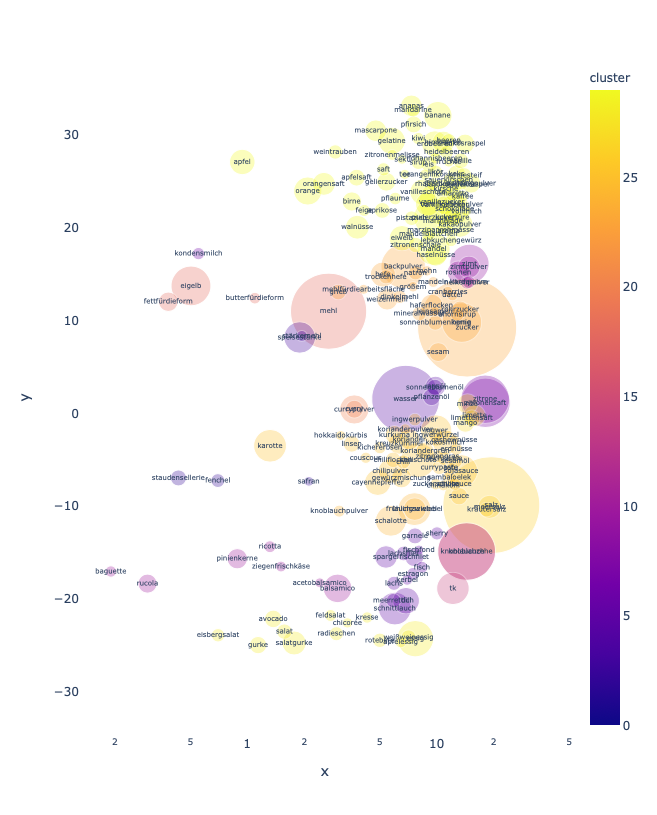

In [90]:
import plotly.express as px
from plotly.graph_objs import *


fig = px.scatter(df_plot, x="x", y="y",
         size="size", color="cluster", text="name",log_x=True, size_max=70,opacity=0.3)

fig.update_traces(textposition='middle center', textfont_size=7)


fig.update_layout(
    height=800,
    width = 1000,
    uniformtext_minsize=3,
    plot_bgcolor = 'white')


fig.show()

In [48]:
model.wv.most_similar("zucker")

[('honig', 0.6807121634483337),
 ('rohrzucker', 0.6631439924240112),
 ('puderzucker', 0.6437190771102905),
 ('grünkohloderwirsing', 0.620855450630188),
 ('speisestärke', 0.6118991374969482),
 ('quarkoderschichtkäseoderricotta', 0.593627393245697),
 ('haferflocken-*', 0.5893736481666565),
 ('stärkemehl', 0.5779958963394165),
 ('backmischungfürkrustenbrot', 0.5776486992835999),
 ('butterfürdiezucker-reduktion', 0.5762193202972412)]